In [1]:
### Reverse layerwise propogation

In [1]:
import tensorflow as tf
import pandas as pd
import xarray as xr
from glob import glob
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cartopy.crs as ccrs
import pickle
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/pydda_env/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [27]:
class LayerwiseRelevancePropogation():
    def __init__(self, model):
        self.model = model
        self.epsilon = 1e-6
        # Count the number of input layers --> Number of CNN networks
        self.no_inputs = 0
        self.pooling_type = "max"
        for x in model.layers:
            if 'input_' in x.name:
                self.no_inputs += 1
    
        
    def backprop_dense(self, x, w, r):
        w_pos = tf.maximum(w, 0.0)
        z = tf.matmul(x, w_pos) + self.epsilon
        s = r / z
        c = tf.matmul(s, tf.transpose(w_pos))
        return c * x
    
    def backprop_flatten(self, x, r):
        return tf.reshape(r, tf.shape(x))
    
    def relprop_add(self, x, r):
        z = tf.add_n(x)
        s = r / z
        c = s
        return c * x
        
    def relprop_batchnorm(self, x, r, w):
        gamma = w[0]
        beta = w[1]
        mmean = w[2]
        mvar = w[3]
        z = tf.nn.batch_normalization(x, mmean, mvar, beta, gamma, self.epsilon) + self.epsilon
        s = r / z
        with tf.GradientTape() as g:
            g.watch(s)
            R = tf.nn.batch_normalization(s, mmean, mvar, beta, gamma, self.epsilon)
        c = g.gradient(R, s)
        return c * x
     
    def relprop_conv(self, x, w, r, strides=(1, 1, 1, 1), padding='SAME'):
        if len(strides) == 2:
            strides = (1, strides[0], strides[1], 1)
        w_pos = tf.maximum(w, 0.0)
        z = tf.nn.conv2d(x, w_pos, strides, padding) + self.epsilon
        s = r / z
        c = tf.compat.v1.nn.conv2d_backprop_input(tf.shape(x), w_pos, s, strides, padding)
        return c * x

    def relprop_pool(self, x, r, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding='SAME'):
        if len(strides) == 2:
            strides = (1, strides[0], strides[1], 1)
        if len(ksize) == 2:
            ksize = (1, ksize[0], ksize[1], 1)
        if self.pooling_type == 'avg':
            z = tf.nn.avg_pool(x, ksize, strides, padding) + self.epsilon
            s = r / z
            with tf.GradientTape() as g:
                g.watch(s)
                R = tf.nn.avg_pool(s, ksize, strides, padding)
            c = g.gradient(R, s)
        elif self.pooling_type == 'max':
            z = tf.nn.max_pool(x, ksize, strides, padding) + self.epsilon
            s = r / z
            c = tf.raw_ops.MaxPoolGradV2(orig_input=x, orig_output=z, grad=s, ksize=ksize, strides=strides, padding=padding)  
        else:
            raise Exception('Error: no such unpooling operation.')
        return c * x

    def calc_relevance(self, inputs, outputs):
        if len(list(inputs.keys())) != self.no_inputs:
            raise InputError("Not enough inputs for model. Need %d inputs" % self.no_inputs)
        cur_layer = self.model.layers[-1]
        cur_relevance = outputs
        output_relevances = {}
        output_relevances["outputs"] = outputs
        # Evaluate x for each layer:
        x_layers = inputs.copy()
        for my_layer in self.model.layers:
            if not isinstance(my_layer.input, list):
                x_layers[my_layer.name.split("/")[0]] = my_layer(x_layers[my_layer.input.name.split("/")[0]])
            else:
                x_layers[my_layer.name.split("/")[0]] = my_layer(list(x_layers[y.name.split("/")[0]] for y in my_layer.input))
                
        x_layers["outputs"] = outputs
        # Backpropgate relevances
        for my_layer in self.model.layers[-1:0:-1]:
            if not isinstance(my_layer.input, list):
                inp_layer_name = my_layer.input.name.split("/")[0]
            
            if 'add' in my_layer.name:
                x_list = [x_layers[g.name.split("/")[0]] for g in my_layer.input]
                out_layer_name = my_layer._outbound_nodes[0].outputs.name.split("/")[0]
                add_relevances = tf.split(self.relprop_add(
                    x_list, output_relevances[out_layer_name]), self.no_inputs, axis=0)
                continue
                    
            inp_layer = self.model.get_layer(inp_layer_name)
            try:
                out_layer_name = my_layer._outbound_nodes[0].outputs.name.split("/")[0]
            except IndexError:
                out_layer_name = "outputs"
            
            if 'dense' in my_layer.name or 'class' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.backprop_dense(
                    x_layers[inp_layer_name], my_layer.weights[0], output_relevances[out_layer_name])
            elif 'conv2d' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_conv(
                    x_layers[inp_layer_name], my_layer.weights[0], output_relevances[out_layer_name],
                    my_layer.strides, my_layer.padding.upper())
            elif 'batch_normalization' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_batchnorm(
                    x_layers[inp_layer_name], output_relevances[out_layer_name], my_layer.weights[0])
            elif 'flatten' in my_layer.name:
                name = my_layer.name.split("/")[0]
                if name[-1] == "n":
                    count = 0
                else:
                    count = int(name.split("_")[1])
                output_relevances[my_layer.name.split("/")[0]] = self.backprop_flatten(
                    x_layers[inp_layer_name], add_relevances[count])
            elif 'max_pooling2d' in my_layer.name:
                output_relevances[my_layer.name.split("/")[0]] = self.relprop_pool(
                    x_layers[inp_layer_name], output_relevances[out_layer_name], my_layer.pool_size,
                    my_layer.strides, my_layer.padding.upper())
            elif 'input' in my_layer.name:
                output_relevances[my_layer.name] = output_relevances[out_layer_name]

        
        return output_relevances

In [3]:
my_model = tf.keras.models.load_model('/lcrc/group/earthscience/rjackson/opencrums/models/classifier')
my_model.summary()

2022-03-24 12:48:03.902578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-24 12:48:03.902738: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-24 12:48:04.007574: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:90:00.0 name: NVIDIA A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2022-03-24 12:48:04.007619: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-24 12:48:04.007659: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-24 12:48:04.007678: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_SSMASS (InputLayer)       [(None, 20, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_SSFLUXU (InputLayer)      [(None, 20, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_SSFLUXV (InputLayer)      [(None, 20, 32, 1)]  0                                            
__________________________________________________________________________________________________
input_SO4MASS (InputLayer)      [(None, 20, 32, 1)]  0                                            
______________________________________________________________________________________________

In [15]:
air_now_data = glob('/lcrc/group/earthscience/rjackson/epa_air_now/*.csv')
air_now_df = pd.concat(map(pd.read_csv, air_now_data))
air_now_df['datetime'] = pd.to_datetime(air_now_df['DateObserved'] + ' 00:00:00')
air_now_df = air_now_df.set_index('datetime')
air_now_df = air_now_df.sort_index()
print(air_now_df['CategoryNumber'].values.min())

batch_size = 16

def get_air_now_label(time):
    if np.min(np.abs((air_now_df.index - time))) > timedelta(days=1):
        return np.nan
    ind = np.argmin(np.abs(air_now_df.index - time))
    return air_now_df['CategoryNumber'].values[ind]

def load_data(species):
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/%sCMASS*.nc' % species).sortby('time')
    print(ds)
    times = np.array(list(map(pd.to_datetime, ds.time.values)))
    x = ds["%sCMASS" % species].values
    old_shape = x.shape
    scaler = StandardScaler()
    scaler.fit(np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = scaler.transform(
            np.reshape(x, (old_shape[0], old_shape[1] * old_shape[2])))
    x = np.reshape(x, old_shape)
    inputs = np.zeros((old_shape[0], old_shape[1], old_shape[2], 3))
    inputs[:, :, :, 0] = x
    ds.close()
    if species == "SO4" or species == "DMS" or species == "SO2":
       inp = "SU"
    else:
       inp = species
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/%sFLUXU*.nc' % inp).sortby('time')
    x2 = ds["%sFLUXU" % inp].values
    scaler = StandardScaler()
    scaler.fit(np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = scaler.transform(
            np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = np.reshape(x2, old_shape)
    inputs[:, :, :, 1] = x2
    ds.close()
    ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/MERRA2/hou_reduced/%sFLUXV*.nc' % inp).sortby('time')
    x2 = ds["%sFLUXV" % inp].values
    scaler = StandardScaler()
    scaler.fit(np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = scaler.transform(
            np.reshape(x2, (old_shape[0], old_shape[1] * old_shape[2])))
    x2 = np.reshape(x2, old_shape)
    inputs[:, :, :, 2] = x2
    classification = np.array(list(map(get_air_now_label, times)))
    where_valid = np.isfinite(classification)
    inputs = inputs[where_valid, :, :, :]
    classification = classification[where_valid]
    times = times[where_valid]
    print(times.shape, classification.shape)
    y = np.concatenate([tf.one_hot(classification, 5).numpy(), times[:, np.newaxis]], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(
            inputs, y, test_size=0.20, random_state=3)
    x
    shape = inputs.shape
    x_dataset_train = {'input_%sMASS' % species: x_train[:, :, :, 0],
            'input_%sFLUXU' % inp: x_train[:, :, :, 1],
            'input_%sFLUXV' % inp: x_train[:, :, :, 2]}
    x_dataset_test = {'input_%sMASS' % species: x_test[:, :, :, 0],
            'input_%sFLUXU' % inp: x_test[:, :, :, 1],
            'input_%sFLUXV' % inp: x_test[:, :, :, 2]}

    return x_dataset_train, x_dataset_test, y_train[:,:5], y_test[:,:5], shape, y_train[:,5], y_test[:,5]

x_ds_train = {}
x_ds_test = {}
y_train = []
y_test = []
species_list = ['SS', 'SO4', 'SO2', 'OC','DU', 'DMS', 'BC']
for species in species_list:
    x_ds_train1, x_ds_test1, y_train, y_test, shape, t_train, t_test = load_data(species)
    x_ds_train.update(x_ds_train1)
    x_ds_test.update(x_ds_test1)

for key in x_ds_test.keys():
    x_ds_train[key] = x_ds_train[key][:, :, :, np.newaxis]
    x_ds_test[key] = x_ds_test[key][:, :, :, np.newaxis]

1
<xarray.Dataset>
Dimensions:    (lon: 32, lat: 20, time: 90744)
Coordinates:
  * lon        (lon) float64 -105.0 -104.4 -103.8 ... -86.88 -86.25 -85.62
  * lat        (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.0 33.5 34.0 34.5
  * time       (time) datetime64[ns] 2010-01-01T00:30:00 ... 2020-05-08T23:30:00
Data variables:
    SSCMASS    (time, lat, lon) float32 dask.array<chunksize=(8760, 20, 32), meta=np.ndarray>
    SSCMASS25  (time, lat, lon) float32 dask.array<chunksize=(8760, 20, 32), meta=np.ndarray>
(64632,) (64632,)
<xarray.Dataset>
Dimensions:   (lon: 32, lat: 20, time: 90744)
Coordinates:
  * lon       (lon) float64 -105.0 -104.4 -103.8 -103.1 ... -86.88 -86.25 -85.62
  * lat       (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 33.0 33.5 34.0 34.5
  * time      (time) datetime64[ns] 2010-01-01T00:30:00 ... 2020-05-08T23:30:00
Data variables:
    SO4CMASS  (time, lat, lon) float32 dask.array<chunksize=(8760, 20, 32), meta=np.ndarray>
(64632,) (64632,)
<xarray.Dataset>
Dimensi

In [16]:
y_predict = my_model.predict(x_ds_test)

2022-03-24 14:34:48.075718: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-03-24 14:34:48.093379: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2245815000 Hz
2022-03-24 14:34:48.675428: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-03-24 14:34:51.366732: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-03-24 14:34:51.409867: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-03-24 14:35:01.081412: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [6]:
y_predicts = y_predict.argmax(axis=1)
y_tests = y_test.argmax(axis=1)
matrix = confusion_matrix(y_predicts, y_tests)

/tmp/ipykernel_2743032/1111899644.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'Hazardous', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy'])
/tmp/ipykernel_2743032/1111899644.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'Hazardous', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy'])


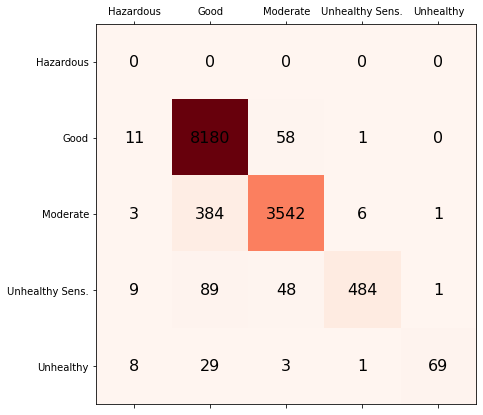

In [7]:
#matrix[matrix == 0] = np.nan
fig = plt.figure(figsize=(7,7))
ax = plt.axes()
ax.matshow(matrix, cmap='Reds')
for (i, j), z in np.ndenumerate(matrix):
    ax.text(j, i, '{:d}'.format(int(z)), ha='center', va='center', color='k', fontsize=16)
ax.set_xticklabels(['', 'Hazardous', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy'])
ax.set_yticklabels(['', 'Hazardous', 'Good', 'Moderate', 'Unhealthy Sens.', 'Unhealthy'])
fig.savefig('confusion_matrix_aqi.png')

In [22]:
def slice_input_ds(x: dict, y, t, start, end):
    x_new = {}
    for key in x.keys():
        x_new[key] = x[key][start:end, :, :, :].copy()
    y_new = y[start:end, :].copy()
    t_test = t[start:end].copy()
    return x_new, y_new, t_test

In [28]:
lrp = LayerwiseRelevancePropogation(my_model)
for i in range(0, y_test.shape[0], 100):
    print(i + 100)
    x_slice, y_slice, t_slice = slice_input_ds(x_ds_test, y_test, t_test, i, i + 100)
    print(x_ds_test['input_SO4MASS'].shape)
    relevance = lrp.calc_relevance(x_slice, y_slice)
    relevance['time'] = t_slice
    with open('relevance%d.pickle' % i, mode='wb') as f:
        pickle.dump(relevance, f)

100
(12927, 20, 32, 1)
200
(12927, 20, 32, 1)
300
(12927, 20, 32, 1)
400
(12927, 20, 32, 1)
500
(12927, 20, 32, 1)
600
(12927, 20, 32, 1)
700
(12927, 20, 32, 1)
800
(12927, 20, 32, 1)
900
(12927, 20, 32, 1)
1000
(12927, 20, 32, 1)
1100
(12927, 20, 32, 1)
1200
(12927, 20, 32, 1)
1300
(12927, 20, 32, 1)
1400
(12927, 20, 32, 1)
1500
(12927, 20, 32, 1)
1600
(12927, 20, 32, 1)
1700
(12927, 20, 32, 1)
1800
(12927, 20, 32, 1)
1900
(12927, 20, 32, 1)
2000
(12927, 20, 32, 1)
2100
(12927, 20, 32, 1)
2200
(12927, 20, 32, 1)
2300
(12927, 20, 32, 1)
2400
(12927, 20, 32, 1)
2500
(12927, 20, 32, 1)
2600
(12927, 20, 32, 1)
2700
(12927, 20, 32, 1)
2800
(12927, 20, 32, 1)
2900
(12927, 20, 32, 1)
3000
(12927, 20, 32, 1)
3100
(12927, 20, 32, 1)
3200
(12927, 20, 32, 1)
3300
(12927, 20, 32, 1)
3400
(12927, 20, 32, 1)
3500
(12927, 20, 32, 1)
3600
(12927, 20, 32, 1)
3700
(12927, 20, 32, 1)
3800
(12927, 20, 32, 1)
3900
(12927, 20, 32, 1)
4000
(12927, 20, 32, 1)
4100
(12927, 20, 32, 1)
4200
(12927, 20, 32, 1)
4

In [21]:
relevance.keys()

dict_keys(['outputs', 'class', 'batch_normalization_36', 'dense_2', 'batch_normalization_35', 'dense_1', 'batch_normalization_34', 'dense', 'flatten_16', 'flatten_15', 'flatten_14', 'flatten_13', 'flatten_12', 'flatten_11', 'flatten_10', 'flatten_9', 'flatten_8', 'flatten_7', 'flatten_6', 'flatten_5', 'flatten_4', 'flatten_3', 'flatten_2', 'flatten_1', 'flatten', 'max_pooling2d_33', 'max_pooling2d_31', 'max_pooling2d_29', 'max_pooling2d_27', 'max_pooling2d_25', 'max_pooling2d_23', 'max_pooling2d_21', 'max_pooling2d_19', 'max_pooling2d_17', 'max_pooling2d_15', 'max_pooling2d_13', 'max_pooling2d_11', 'max_pooling2d_9', 'max_pooling2d_7', 'max_pooling2d_5', 'max_pooling2d_3', 'max_pooling2d_1', 'batch_normalization_33', 'batch_normalization_31', 'batch_normalization_29', 'batch_normalization_27', 'batch_normalization_25', 'batch_normalization_23', 'batch_normalization_21', 'batch_normalization_19', 'batch_normalization_17', 'batch_normalization_15', 'batch_normalization_13', 'batch_normal

In [62]:
y_test.shape

(12927, 5)

In [59]:
y_slice[2]

array([0., 1., 0., 0., 0.], dtype=float32)